In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

import os
import shutil
import subprocess
import gc
import xarray as xr
import numpy as np
import pymp

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import Bbox
from matplotlib.patches import FancyBboxPatch
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

from functions.mandyocIO import read_mandyoc_output, read_datasets, change_dataset, _calc_melt_dry, _calc_melt_wet

In [7]:
path = os.getcwd().split('/') # Get local file
machine_path = '/'+path[1]+'/'+path[2] # Select home according to OS.

# Path to the model directory

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT200_PT1292oC/1x1km2/NHK/RFT_Clc1_DT200_PT1292oC_lit80km_1x1km2_NHK' #ok
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT200_PT1292oC/1x1km2/NHK/RFT_Clc10_DT200_PT1292oC_lit80km_1x1km2_NHK' #ok

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT290_PT1350oC/1x1km2/NHK/RFT_Clc1_DT290_PT1350oC_lit80km_1x1km2_NHK' #ok
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT290_PT1350oC/1x1km2/NHK/RFT_Clc10_DT290_PT1350oC_lit80km_1x1km2_NHK' #ok

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT350_PT1397oC/1x1km2/NHK/RFT_Clc1_DT350_PT1397oC_lit80km_1x1km2_NHK' #ok
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT350_PT1397oC/1x1km2/NHK/RFT_Clc10_DT350_PT1397oC_lit80km_1x1km2_NHK' #ok

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT400_PT1437oC/1x1km2/NHK/RFT_Clc1_DT400_PT1437oC_lit80km_1x1km2_NHK' #ok
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit80km/DT400_PT1437oC/1x1km2/NHK/RFT_Clc10_DT400_PT1437oC_lit80km_1x1km2_NHK' #ok

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT200_PT1352oC/1x1km2/NHK/RTF_Clc1_DT200_PT1352oC_lit150km_1x1km2_NHK' #ok
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT200_PT1352oC/1x1km2/NHK/RTF_Clc10_DT200_PT1352oC_lit150km_1x1km2_NHK' #ok

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT290_PT1421oC/1x1km2/NHK/RFT_Clc1_DT290_PT1421oC_lit150km_1x1km2_NHK' #ok
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT290_PT1421oC/1x1km2/NHK/RFT_Clc10_DT290_PT1421oC_lit150km_1x1km2_NHK' #ok

# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT350_PT1460oC/1x1km2/NHK/RTF_Clc1_DT350_PT1460oC_lit150km_1x1km2_NHK' #ok
# scenario = '/Doutorado/cenarios/mandyoc/rifting/lit150km/DT350_PT1460oC/1x1km2/NHK/RTF_Clc10_DT350_PT1460oC_lit150km_1x1km2_NHK' #

scenario = '/RFT_Clc1_DT200_PT1292oC_lit80km_1x1km2_NHK'

dataset = ['pressure',
		   'temperature',
           'strain',
           'density']

# local = True
local = False
if(local==True):
    model_path = machine_path + scenario
else:
    external_media = 'Joao_Macedo'
    if(path[1] == 'home'):
        model_path = f'/media/joao_macedo/{external_media}{scenario}'
    elif(path[1] == 'Users'):
        model_path = f'/Volumes/{external_media}{scenario}'

# Create the output directory to save the dataset
output_path = os.path.join(model_path, "_output")

if not os.path.isdir(output_path):
    os.makedirs(output_path)


# model_path = machine_path + scenario
dataset = read_datasets(model_path, dataset)

Nx = int(dataset.nx)
Nz = int(dataset.nz)
Lx = float(dataset.lx)
Lz = float(dataset.lz)

dx = Lx/(Nx-1)
dz = Lz/(Nz-1)

dataset

<xarray.Dataset>
Dimensions:      (x: 1001, z: 301, time: 83)
Coordinates:
  * x            (x) float64 0.0 1e+03 2e+03 3e+03 ... 9.98e+05 9.99e+05 1e+06
  * z            (z) float64 -3e+05 -2.99e+05 -2.98e+05 ... -2e+03 -1e+03 0.0
  * time         (time) float64 0.0 0.5 1.0 1.5 2.0 ... 38.11 38.61 39.11 39.61
    step         (time) int32 0 100 200 300 400 500 ... 7800 7900 8000 8100 8200
Data variables:
    pressure     (time, x, z) float64 ...
    temperature  (time, x, z) float64 ...
    strain       (time, x, z) float64 ...
    density      (time, x, z) float64 ...
Attributes: (12/94)
    nx:                                1001
    nz:                                301
    lx:                                1000000.0
    lz:                                300000.0
    multigrid:                         1
    solver:                            direct
    ...                                ...
    temperature_units:                 C
    density_units:                     kg/m^3
    heat_units:                        W/m^3
    viscosity_units:                   Pa s
    strain_rate_units:                 s^(-1)
    pressure_units:                    Pa

In [52]:
t0 = dataset.time[0]
t1 = dataset.time[1]
dt = int(t1 - t0)

# start = 49
# end = 50
# step = 1

start = int(t0)
end = int(dataset.time.size - 1)
step = 1#5

# size = (end+step-start)//step* len(isotherms_list)
Vmelt_dry_evolution = pymp.shared.dict() #dicionario para preservar a ordem
Vmelt_wet_evolution = pymp.shared.dict()

with pymp.Parallel() as p:
    for i in p.range(start, end+step, step):
        # melt_vol_dry = []
        # melt_vol_wet = []
        per = np.round(100*(i+1-start)/(end-start), 2)

        melt_dry = _calc_melt_dry(dataset.temperature[i], dataset.pressure[i])
        Vmelt_dry = np.sum(melt_dry)*dx*dz
         
        melt_wet = _calc_melt_wet(dataset.temperature[i], dataset.pressure[i])
        Vmelt_wet = np.sum(melt_wet)*dx*dz

        Vmelt_dry_evolution[i] = Vmelt_dry #coloca lista inteira na ordem certa para aquele i
        Vmelt_wet_evolution[i] = Vmelt_wet
            
########################################################################################

Vmelt_dry_dict = dict(Vmelt_dry_evolution) #convertendo pra dicionario normal
Vmelt_wet_dict = dict(Vmelt_wet_evolution) #convertendo pra dicionario normal

evol_dry = [] #empty list to concatenated
evol_wet = []

for i, j in zip(sorted(Vmelt_dry_dict), sorted(Vmelt_wet_dict)):#ordenando o dicionario para a ordem do for loop antes de paralelizar
    evol_dry.append(Vmelt_dry_dict[i])
    evol_wet.append(Vmelt_wet_dict[j]) 
    
evol_dry = np.asarray(evol_dry)
# evol_wet = np.asarray(evol_wet)

data_vars = {}
data_vars[f"vmelt_dry"] = evol_dry
data_vars[f"vmelt_wet"] = evol_wet
    
coords = {'time': dataset.time[start:end:step]}

Vmelt_dataset = xr.Dataset(data_vars = data_vars,
                               coords = {'time': dataset.time[start:end+step:step]},
                               attrs=dict(description='Melt Volume evolution', units='%*km*km')
                              )
filename = f"_melt_volume_evolution_dataset.nc"
Vmelt_dataset.to_netcdf(f"{model_path}/{filename}")

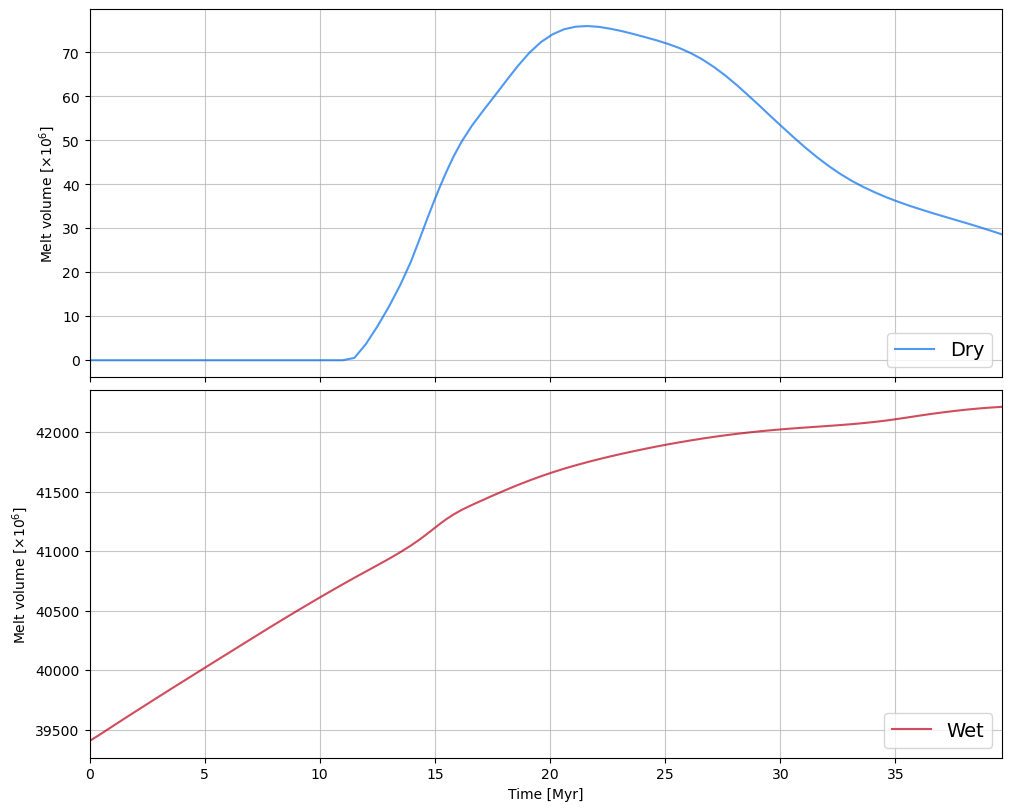

In [62]:
plt.close()
fig, axs = plt.subplots(2, 1, figsize=(10,8), constrained_layout=True, sharex=True)

axs[0].plot(Vmelt_dataset.time, Vmelt_dataset.vmelt_dry/1.0e6, alpha=0.7, label = 'Dry', color='xkcd:cerulean blue')
axs[1].plot(Vmelt_dataset.time, Vmelt_dataset.vmelt_wet/1.0e6, alpha=0.7, label='Wet', color='xkcd:scarlet')

axs[0].set_xlim(0, Vmelt_dataset.time[-1])
# ax.set_ylim([0, 100])
axs[1].set_xlabel('Time [Myr]')

axs[0].set_ylabel(r'Melt volume [$\times 10^6$]')
axs[1].set_ylabel(r'Melt volume [$\times 10^6$]')
axs[0].grid('-k', alpha=0.7)
axs[1].grid('-k', alpha=0.7)
axs[0].legend(loc='lower right', fontsize=14)
axs[1].legend(loc='lower right', fontsize=14)

figname = f"{scenario.split('/')[-1]}_MeltVolume_evolution"
fig.savefig(f"{model_path}/{figname}.pdf", dpi=400)
fig.savefig(f"{model_path}/{figname}.png", dpi=400)